---

# Credit Default Prediction Project

---

## Introduction
In this notebook, we will work with bank customer data to predict credit default using both simple data science tools and more complex machine learning models. <br>
The data contains *various features ranging from client profile to payment history* and then a binary target column reporting whether or not the client defaulted. <br>
We will go about analyzing the data in the following order:
1. Customary library and data import followed by basic dataset information.
2. Cleaning the data and modifying some features to **improve their interpretability** and facilitate later steps.
3. Finding some **early insights about the data** with plots and engineered features that provide more info on the dataset.
4. Creating some machine learning models to **run regressions of the data on the target variable** and understand each feature's impact on the risk of default.

## 1. Imports and dataset summaries

In [1]:
# importing libraries

from sklearn.model_selection import learning_curve, train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, Accuracy, AUC

import statsmodels.formula.api as smf

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns



In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pwd

/Users/charleschaverot/Desktop/Coding/Learning/Other Projects/Real Estate Project


In [4]:
# importing data

data = pd.read_csv('data/credit_card.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [5]:
# 1. No nulls to deal with
# 2. All values are numeric so no need to encode categorical information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [6]:
data.nunique()

ID                            30000
LIMIT_BAL                        81
SEX                               2
EDUCATION                         7
MARRIAGE                          4
AGE                              56
PAY_0                            11
PAY_2                            11
PAY_3                            11
PAY_4                            11
PAY_5                            10
PAY_6                            10
BILL_AMT1                     22723
BILL_AMT2                     22346
BILL_AMT3                     22026
BILL_AMT4                     21548
BILL_AMT5                     21010
BILL_AMT6                     20604
PAY_AMT1                       7943
PAY_AMT2                       7899
PAY_AMT3                       7518
PAY_AMT4                       6937
PAY_AMT5                       6897
PAY_AMT6                       6939
default.payment.next.month        2
dtype: int64

## 2. Data Preprocessing

First, we get rid of rows of the dataset where education level and marital status are unknown.

In [7]:
data = data[data['EDUCATION'].between(1,3)]
data = data[data['MARRIAGE'].between(1,2)]
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [8]:
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

Second, we "one-hot encode" the education feature, separating it into three binary features which will be easier to read for our model.

In [9]:
print((data.sort_values('EDUCATION'))['EDUCATION'].unique())

ohe = OneHotEncoder(sparse = False)    # Do not give results as a sparse matrix, easier to work with

ohe.fit(data[['EDUCATION']])
education_encoded = ohe.transform(data[['EDUCATION']])
data[['grad_school', 'university', 'high_school']] = education_encoded
data = data.drop(columns='EDUCATION')

[1 2 3]


We also reformat SEX and MARRIAGE columns into binary features and drop the old ones.

In [10]:
data['male'] = (data['SEX']==1).astype('int')
data['married'] = (data['MARRIAGE']==1).astype('int')
data = data.drop(columns = ['MARRIAGE', 'SEX'])

We make all column names lower-case for readibility.

In [11]:
data.columns = [x.lower() for x in ['ID', 'LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default',
       'grad_school', 'university', 'high_school', 'male', 'married']]

Columns are reorganized to bring our new engineered features to the forefront.

In [12]:
data = data[['limit_bal', 'age', 'male', 'married', 'grad_school',
       'university', 'high_school', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5',
       'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4',
       'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3',
       'pay_amt4', 'pay_amt5', 'pay_amt6', 'default']]

Duly paid values are set to zero.

In [13]:
pays = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']

for p in pays:
    data.loc[data[p]<=0, p] = 0

In [14]:
data.head()

,limit_bal,age,male,married,grad_school,university,high_school,pay_0,pay_2,pay_3,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,20000.0,24,0,1,0.0,1.0,0.0,2,2,0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,26,0,0,0.0,1.0,0.0,0,2,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,34,0,0,0.0,1.0,0.0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,37,0,1,0.0,1.0,0.0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,57,1,1,0.0,1.0,0.0,0,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In order to do statistical analysis, we must have a dataset with balanced amounts of 0 and 1 in the target variable. <br>
Here, we check for this balance and the amount of each value's occurences in the target variable.

In [15]:
data.default.value_counts() # -> we have an unbalanced dataset 
# we will have to use SMOTE to oversample the 'default=1' class

0    22649
1     6514
Name: default, dtype: int64

As we can see, we have a strongly imbalanced dataset. There are 22,659 rows of non-default for only 6,514 rows of default. <br>
Thanks to the SMOTE function, we will be able to rebalance the dataset in order to have more meaningful findings. <br> <br>
Careful though, rebalancing can only be done for the training set (part of the dataset used to train the models on) as we will need to test our model on untouched data.

In [16]:
X = data.drop(columns='default')
y = data['default']

Here we separate dataset into train and test subsets (putting 70% of the dataset into the training set) before resampling the training set using SMOTE.

In [17]:
# scaling the data solves the vanishing gradient problem
# by shrinking the interval of the values, we give more significance to the relationship between them
st_scaler = StandardScaler()

X = pd.DataFrame(st_scaler.fit_transform(X), columns=X.columns)

In [18]:
X_t, X_test, y_t, y_test = train_test_split(X,y, test_size=0.3)

X_train, y_train = SMOTE().fit_resample(X_t, y_t)

In [19]:
for df in [X_train, X_test, y_train, y_test]:
    df = df.reset_index(drop=True)

In [20]:
print ("Imbalanced training set: \n", y_t.value_counts(), "\n")
print ("Balanced training set: \n", y_train.value_counts())

Imbalanced training set: 
 0    15914
1     4500
Name: default, dtype: int64 

Balanced training set: 
 0    15914
1    15914
Name: default, dtype: int64


By using robust scaler, we can mitigate the impact of outliers. <br>
This does not impact the results of the model's training as the relationships between the values of the dataset are conserved.

In [21]:
X_train.head()

,limit_bal,age,male,married,grad_school,university,high_school,pay_0,pay_2,pay_3,...,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,1.014057,0.284216,-0.811245,1.082724,1.330133,-0.951816,-0.442208,-0.470462,-0.401776,-0.387203,...,-0.677254,-0.671952,-0.663420,-0.653537,-0.341153,-0.265662,-0.307629,-0.255870,-0.316060,-0.293887
1,-0.754119,-1.349562,-0.811245,-0.923597,-0.751805,1.050623,-0.442208,-0.470462,-0.401776,-0.387203,...,-0.248524,-0.221393,-0.197682,-0.375703,-0.103201,-0.193474,-0.261494,-0.248590,-0.276529,-0.180938
2,-1.061628,0.828809,-0.811245,1.082724,-0.751805,-0.951816,2.261379,-0.470462,-0.401776,-0.387203,...,-0.454135,-0.433317,-0.405872,-0.402164,-0.262109,-0.202300,-0.289353,-0.293182,-0.296295,-0.193927
3,0.860303,0.393134,-0.811245,1.082724,1.330133,-0.951816,-0.442208,-0.470462,-0.401776,-0.387203,...,-0.675291,-0.671952,-0.663420,-0.647672,-0.355537,-0.259507,-0.307629,-0.313593,-0.293000,-0.277114
4,-1.061628,0.828809,-0.811245,1.082724,-0.751805,-0.951816,2.261379,0.840457,2.079589,-0.387203,...,-0.289051,-0.309293,-0.355643,-0.398209,-0.355537,-0.199222,-0.214526,-0.275176,-0.283842,-0.271975


##  3. Early data insights

### 2.1 *Top 10 features with highest impact on default outcome*

In [22]:
target_impact = data.corr()['default'].sort_values(ascending=False)[1:]
target_impact_abs = data.corr()['default'].abs().sort_values(ascending=False)[1:]

ft_list = []

for feature_name in target_impact_abs.head(10).index:
    ft_list.append(feature_name)
    
target_impact[ft_list]

pay_0        0.399031
pay_2        0.328039
pay_3        0.286201
pay_4        0.267379
pay_5        0.260932
pay_6        0.244964
limit_bal   -0.153576
pay_amt1    -0.076875
pay_amt2    -0.060498
pay_amt4    -0.057570
Name: default, dtype: float64

#### Interpretation:
- We can see that the features with the most impact on credit default outcome are all related to payments of the credit bills.
- Additionally, we observe that **earlier payments should be most scrutinized** for their default prediction capability.
- This will be a useful basis for **dimensionality reduction** in the deep learning model improvement part.

### 2.2 Impact of gender on default probability

In [23]:
# find the share of all the profiles in the dataset that have defaulted
frac_default = len(data[data["default"]==1]) / len(data)
# this could also be found by "np.mean(data["default"]) * 100" but the equation makes more sense
                                                  
data_default = round((frac_default)*100,2)
data_default

22.34

In [24]:
males = data[data["male"]==1]

male_default = round(len(males[males["default"]==1]) / len(males)*100,2)

In [25]:
females = data[data["male"]==0]

female_default = round(len(females[females["default"]==1]) / len(females)*100,2)

### 2.3 Impacts of marital status, education level and credit card balance limit on default probability

In [26]:
married = data[data["married"]==1]

married_default = round(len(married[married["default"]==1]) / len(married)*100,2)

In [27]:
hs = data[data["high_school"]==1]

hs_default = round(len(hs[hs["default"]==1]) / len(hs)*100,2)

In [28]:
uni = data[data["university"]==1]

uni_default = round(len(uni[uni["default"]==1]) / len(uni)*100,2)

In [29]:
grad = data[data["grad_school"]==1]

grad_default = round(len(grad[grad["default"]==1]) / len(grad)*100,2)

### 2.4 Results

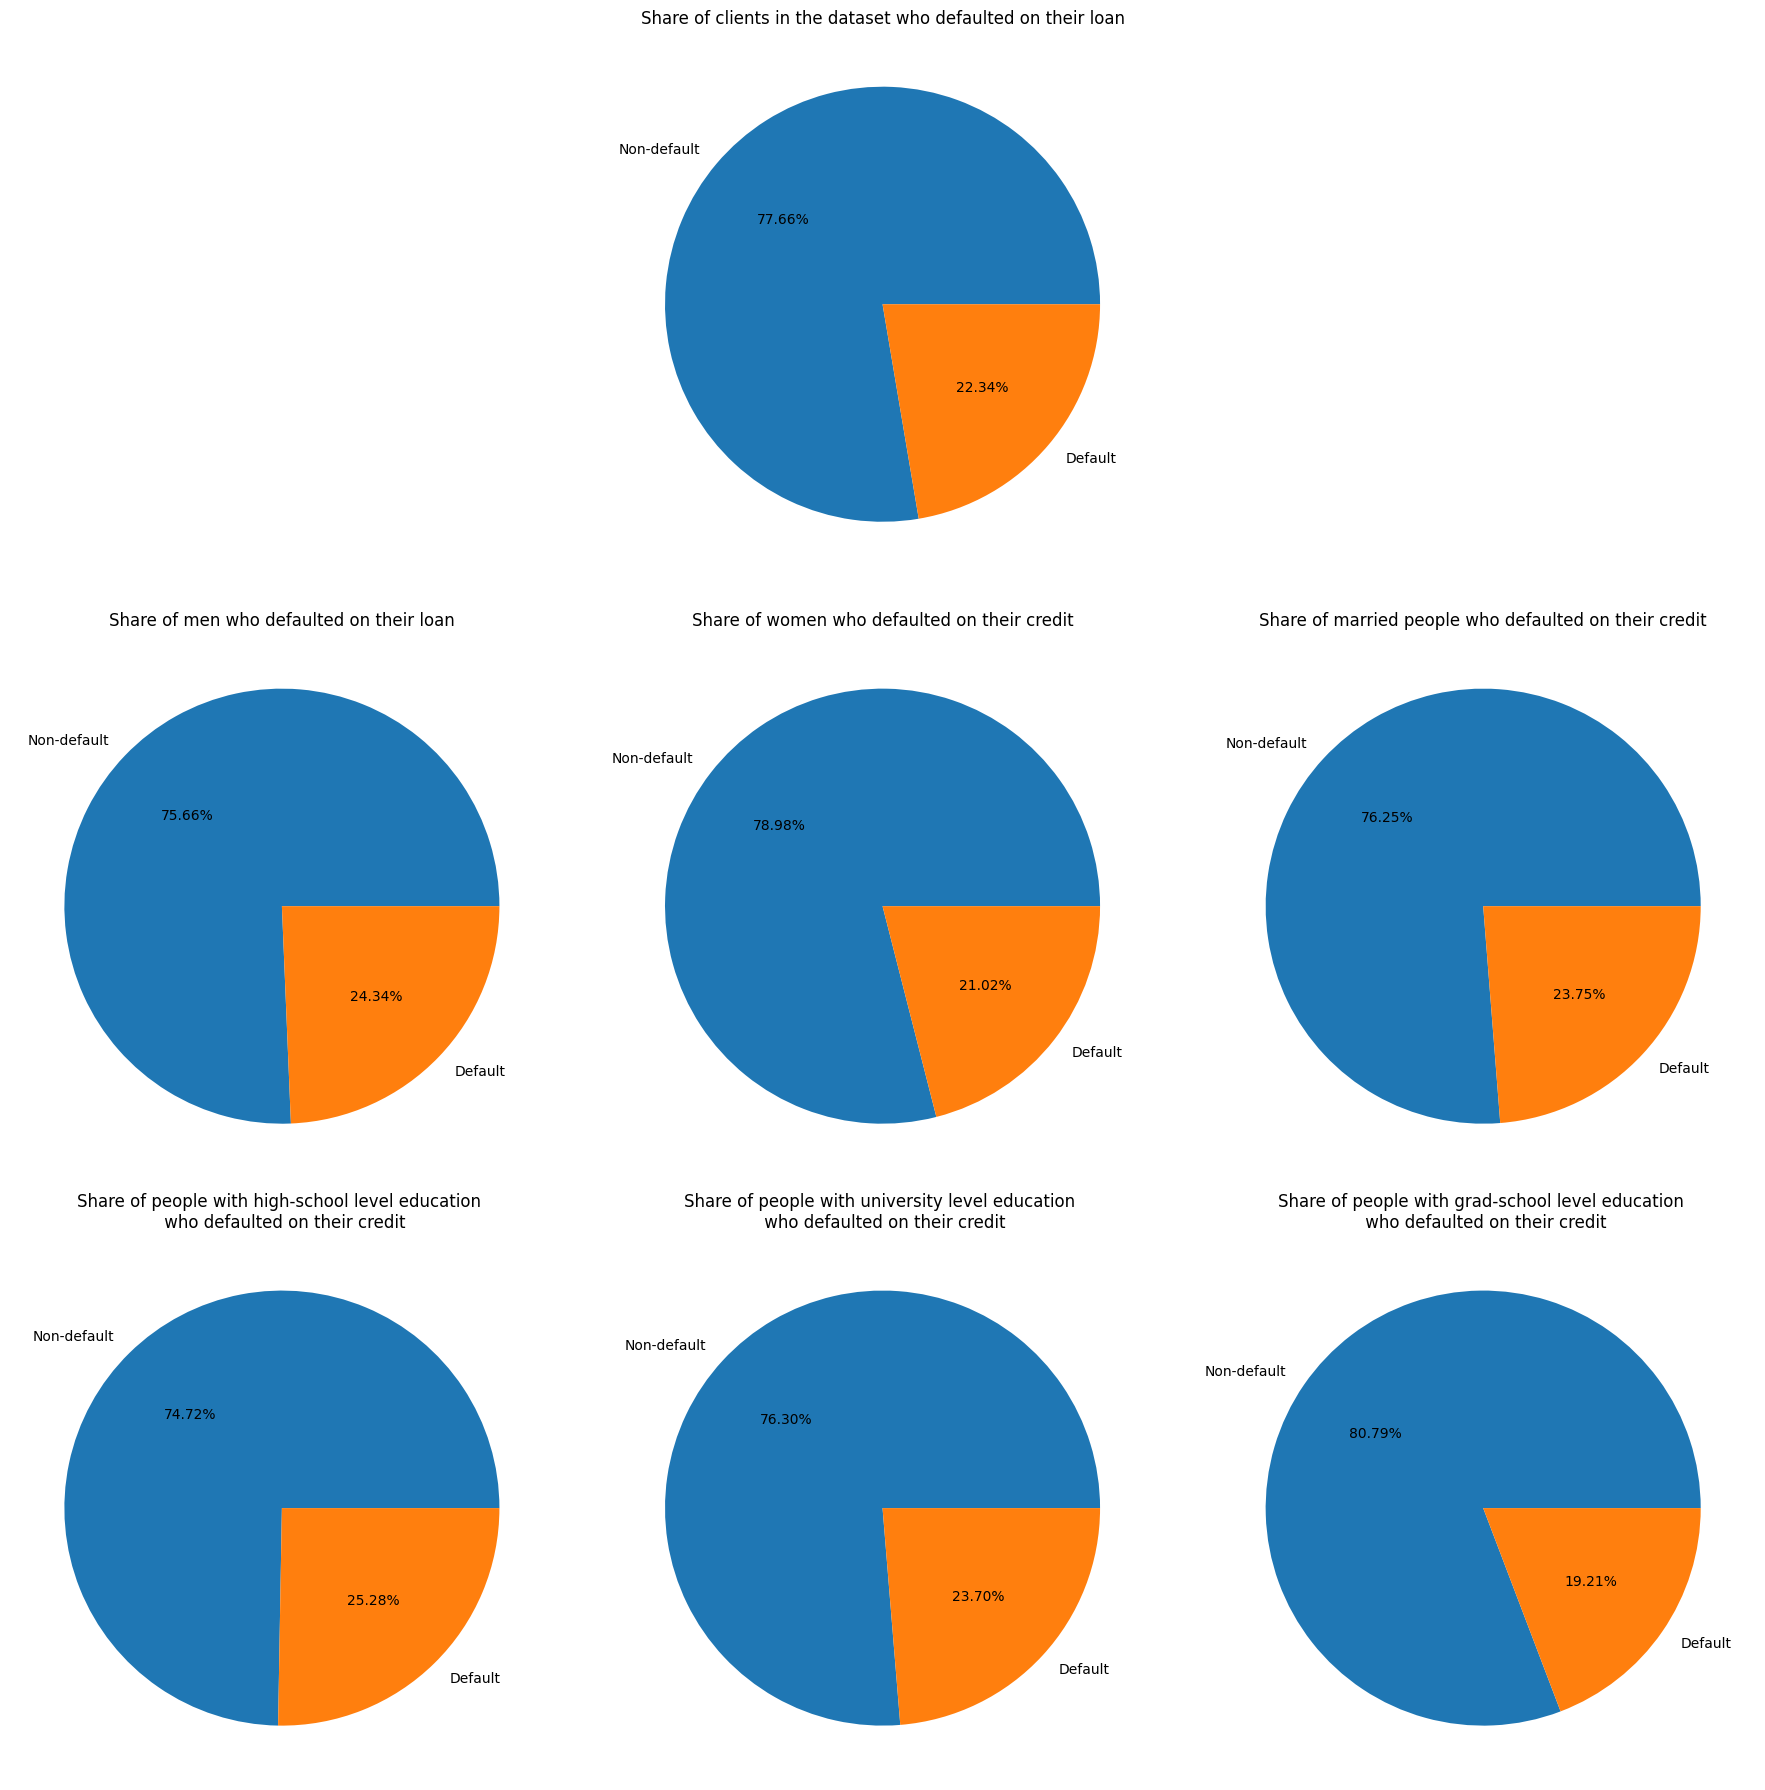

In [30]:
fig = plt.figure(figsize=(18,18))

# first row, first column (spanning both rows)
ax1 = plt.subplot2grid((3,3),(0,0), colspan=3)
plt.pie([1-data_default/100, data_default/100], labels = ['Non-default', 'Default'], autopct="%.2f%%")
plt.title("Share of clients in the dataset who defaulted on their loan")

# Second row first column
ax1 = plt.subplot2grid((3,3), (1, 0))
plt.pie([1-male_default/100, male_default/100], labels = ['Non-default', 'Default'], autopct="%.2f%%")
plt.title("Share of men who defaulted on their loan")

# Second row second column
ax1 = plt.subplot2grid((3,3), (1, 1))
plt.pie([1-female_default/100, female_default/100], labels = ['Non-default', 'Default'], autopct="%.2f%%")
plt.title("Share of women who defaulted on their credit")

# Second row third column
ax1 = plt.subplot2grid((3,3), (1,2))
plt.pie([1-married_default/100, married_default/100], labels = ['Non-default', 'Default'], autopct="%.2f%%")
plt.title("Share of married people who defaulted on their credit")

# Third row first column
ax1 = plt.subplot2grid((3,3), (2,0))
plt.pie([1-hs_default/100, hs_default/100], labels = ['Non-default', 'Default'], autopct="%.2f%%")
plt.title("Share of people with high-school level education \n who defaulted on their credit")


# Third row second column
ax1 = plt.subplot2grid((3,3), (2,1))
plt.pie([1-uni_default/100, uni_default/100], labels = ['Non-default', 'Default'], autopct="%.2f%%")
plt.title("Share of people with university level education \n who defaulted on their credit")

# Third row third column
ax1 = plt.subplot2grid((3,3), (2,2))
plt.pie([1-grad_default/100, grad_default/100], labels = ['Non-default', 'Default'], autopct="%.2f%%")
plt.title("Share of people with grad-school level education \n who defaulted on their credit")


plt.tight_layout()
plt.show()

#### Interpretation:
- We can see that in our data, **the "benchmark" share of default is 22.34%**. This is the value that we will compare other groups' default rates to.

1. Gender
    - Here we can see that 24.34% of male clients have defaulted on their credit card balances. This represents a 2 percentage points increase from the benchmark.
    - In contrast, 21.02% of women have defaulted or a decrease of 1.32 percentage points from the benchmark.
    - From the perspective of a bank, this means that **extending credit to men is riskier than to women by 3.32 percentage points**. This could be useful to calculate credit card APR or benchmarks for credit scores.

<br>

2. Marital status
    - From our analysis, the fact of a client being married brings an **1.41 percentage points increase** in their probability of having defaulted.

<br>

3. Education level
    - We can observe the following impacts from maximum education level attained <br>
    - *High School*: **2.94 percentage points increase** in probability of having defaulted
    - *University*: **1.38 percentage points increase**
    - *Graduate School*: **3.13 percentage points decrease**
    

## 4. Machine learning models

### Basic Logistic Regression

In [31]:
model = LogisticRegression()

model.fit(X_train, y_train)

cv_result = cross_validate(model, X_test, y_test, scoring = ['f1', 'accuracy'])

f1 = cv_result['test_f1'].mean()
acc = cv_result['test_accuracy'].mean()

print ('F1 score: {} \nAccuracy score: {}'.format(f1,acc))

F1 score: 0.4591011548665708 
Accuracy score: 0.81323538348444


### Recurrent Neural Network

In [32]:
def make_model(X, y, neurons=40, optimizer="adam", l_rate=0.001):
    
    # initializing
    
    model = Sequential([
        

        Dense(60, activation="relu"),
        Dropout(0.5),
        
      
        Dense(200, activation="relu"),
        Dropout(0.5),

        
      
        Dense(1, activation="sigmoid")
        ])
        
    # compiling
        
    if optimizer=="adam":
        opt = tf.keras.optimizers.Adam(learning_rate=l_rate)
    elif optimizer == "rmsprop":
        opt = tf.keras.optimizers.RMSprop(learning_rate=l_rate)
    model.compile(loss="binary_crossentropy",
                 optimizer=opt,
                 metrics=["accuracy"])
   
        
    # fitting
        
    es = EarlyStopping(restore_best_weights=True, patience = 4, monitor="loss")  
    model.fit(X, y,
             epochs = 10,
             callbacks = es,
             batch_size = 32,
             verbose=1)
    
    return model

In [33]:
model = make_model(X_train, y_train)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-12 21:47:53.960303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-12 21:47:53.962453: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-12 21:47:54.184396: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2023-03-12 21:47:54.460030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


995/995 [==============================] - 7s 6ms/step - loss: 0.6002 - accuracy: 0.6893
Epoch 2/10
995/995 [==============================] - 7s 7ms/step - loss: 0.5753 - accuracy: 0.7053
Epoch 3/10
995/995 [==============================] - 6s 6ms/step - loss: 0.5680 - accuracy: 0.7066
Epoch 4/10
995/995 [==============================] - 6s 6ms/step - loss: 0.5632 - accuracy: 0.7099
Epoch 5/10
995/995 [==============================] - 6s 6ms/step - loss: 0.5614 - accuracy: 0.7094
Epoch 6/10
995/995 [==============================] - 7s 7ms/step - loss: 0.5588 - accuracy: 0.7124
Epoch 7/10
995/995 [==============================] - 6s 6ms/step - loss: 0.5579 - accuracy: 0.7108
Epoch 8/10
995/995 [==============================] - 6s 6ms/step - loss: 0.5549 - accuracy: 0.7127
Epoch 9/10
995/995 [==============================] - 6s 6ms/step - loss: 0.5556 - accuracy: 0.7108
Epoch 10/10
995/995 [==============================] - 6s 6ms/step - loss: 0.5535 - accuracy: 0.7138


### Results
We get accuracy of 82% with the Logistic Regression and 71% with our Recurrent Neural Network.
Next, we will look at how modifying the dataset can help improve our models.